# **Árboles de decisión**

## Introducción

Vamos a clasificar mediante árboles de decisión, una técnica de aprendizaje automático para tomar decisiones basadas en datos.

El conjunto de datos utilizado en este laboratorio corresponde a la predicción de medicamentos basada en los parámetros de salud de un paciente.


Importamos las librerías necesarias.


In [ ]:

import numpy as np  # Biblioteca para operaciones numéricas
import pandas as pd  # Biblioteca para manipulación de datos en estructuras tipo DataFrame
from matplotlib import pyplot as plt  # Biblioteca para visualización de gráficos
from sklearn.preprocessing import LabelEncoder  # Para convertir variables categóricas en numéricas
from sklearn.model_selection import train_test_split  # Para dividir el conjunto de datos en entrenamiento y prueba
from sklearn.tree import DecisionTreeClassifier, plot_tree  # Para crear y visualizar árboles de decisión
from sklearn import metrics  # Para evaluar el rendimiento del modelo

# Supresión de advertencias para evitar mensajes innecesarios durante la ejecución
import warnings
warnings.filterwarnings('ignore')


### Acerca del conjunto de datos
Imagina que eres un investigador médico recopilando datos para un estudio. Has reunido información sobre un grupo de pacientes, todos los cuales padecieron la misma enfermedad. Durante su tratamiento, cada paciente respondió a uno de cinco medicamentos: Drug A, Drug B, Drug C, Drug X y Drug Y.

Parte de tu trabajo consiste en construir un modelo que permita determinar qué medicamento podría ser adecuado para un futuro paciente con la misma enfermedad. Las características de este conjunto de datos son la edad, el sexo, la presión arterial y el colesterol de los pacientes, y el objetivo es el medicamento al que cada paciente respondió.

Se trata de un ejemplo de clasificador multiclase.

Puedes utilizar la parte de entrenamiento del conjunto de datos para construir un árbol de decisión, y luego usarlo para predecir la clase de un paciente desconocido o para prescribir un medicamento a un nuevo paciente.


### Descarga de datos
    


In [ ]:
# Ruta del archivo CSV que contiene el conjunto de datos
path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv'

# Lectura del archivo CSV desde la URL y carga en un DataFrame de pandas
my_data = pd.read_csv(path)

# Visualización del contenido del DataFrame
my_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


### Análisis y preprocesamiento de datos
Debes aplicar algunos pasos básicos de análisis para comprender mejor los datos. Primero, vamos a recopilar información básica sobre el conjunto de datos.


In [ ]:

# Muestra información general sobre el DataFrame, incluyendo el número de entradas, nombres de columnas, tipos de datos y cantidad de valores no nulos en cada columna
my_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


Esto nos indica que 4 de las 6 características de este conjunto de datos son categóricas, por lo que deberán convertirse en variables numéricas para poder ser utilizadas en el modelado. Para ello, podemos utilizar LabelEncoder de la biblioteca Scikit-Learn.

In [ ]:

# Se crea una instancia del codificador de etiquetas (LabelEncoder), que convierte valores categóricos en números
label_encoder = LabelEncoder()

# Se codifica la columna 'Sex' (Sexo) transformando sus valores categóricos en valores numéricos
my_data['Sex'] = label_encoder.fit_transform(my_data['Sex'])

# Se codifica la columna 'BP' (Presión arterial) transformando sus valores categóricos en valores numéricos
my_data['BP'] = label_encoder.fit_transform(my_data['BP'])

# Se codifica la columna 'Cholesterol' (Colesterol) transformando sus valores categóricos en valores numéricos
my_data['Cholesterol'] = label_encoder.fit_transform(my_data['Cholesterol'])

# Se muestra el DataFrame actualizado con las columnas categóricas ya transformadas en numéricas
my_data


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,drugY
1,47,1,1,0,13.093,drugC
2,47,1,1,0,10.114,drugC
3,28,0,2,0,7.798,drugX
4,61,0,1,0,18.043,drugY
...,...,...,...,...,...,...
195,56,0,1,0,11.567,drugC
196,16,1,1,0,12.006,drugC
197,52,1,2,0,9.894,drugX
198,23,1,2,1,14.020,drugX


Con esto, ahora tienes 5 parámetros que pueden utilizarse para el modelado y 1 característica como variable objetivo. Podemos observar, al comparar los datos antes y después de aplicar la codificación de etiquetas, el siguiente mapeo:

<br>
Para el parámetro género 'Sex' : $M \rightarrow 1, F \rightarrow 0$ <br>
Para el parámetro presión arterial 'BP' : $High (Alta) \rightarrow 0, Low (Baja) \rightarrow 1, Normal \rightarrow 2$<br>
Para el parámetro colesterol 'Cholesterol' : $High (Alto) \rightarrow 0, Normal \rightarrow 1$

También puedes verificar si hay valores faltantes en el conjunto de datos.

In [ ]:
# Verifica si hay valores nulos en cada columna del DataFrame y muestra la cantidad de valores faltantes por columna
my_data.isnull().sum()

,0
Age,0
Sex,0
BP,0
Cholesterol,0
Na_to_K,0
Drug,0


Esto nos indica que no hay valores faltantes en ninguno de los campos.

Para evaluar la correlación de la variable objetivo con las características de entrada, será conveniente asignar un valor numérico a los diferentes medicamentos.


In [ ]:
# Se define un diccionario que asigna un valor numérico a cada tipo de medicamento
custom_map = {'drugA': 0, 'drugB': 1, 'drugC': 2, 'drugX': 3, 'drugY': 4}

# Se crea una nueva columna 'Drug_num' en el DataFrame, que contiene los valores numéricos correspondientes a cada medicamento
my_data['Drug_num'] = my_data['Drug'].map(custom_map)

# Se muestra el DataFrame actualizado con la nueva columna numérica para los medicamentos
my_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Drug_num
0,23,0,0,0,25.355,drugY,4
1,47,1,1,0,13.093,drugC,2
2,47,1,1,0,10.114,drugC,2
3,28,0,2,0,7.798,drugX,3
4,61,0,1,0,18.043,drugY,4
...,...,...,...,...,...,...,...
195,56,0,1,0,11.567,drugC,2
196,16,1,1,0,12.006,drugC,2
197,52,1,2,0,9.894,drugX,3
198,23,1,2,1,14.020,drugX,3


Ahora puedes usar la función corr() para encontrar la correlación de las variables de entrada con la variable objetivo.

#### Encontrar la correlación de las variables de entrada con la variable objetivo e identificar las características que afectan más significativamente a dicha variable.

In [ ]:
# Se elimina la columna 'Drug' (que contiene los nombres de los medicamentos) ya que no es numérica y no se puede usar en el cálculo de correlaciones
# Luego se calcula la matriz de correlación entre todas las variables numéricas del DataFrame
# Finalmente, se extrae la columna 'Drug_num' para ver cómo se correlaciona con las demás variables
my_data.drop('Drug', axis=1).corr()['Drug_num']

,Drug_num
Age,-0.004828
Sex,-0.098573
BP,0.372868
Cholesterol,0.055629
Na_to_K,0.589120
Drug_num,1.000000


También podemos comprender la distribución del conjunto de datos representando gráficamente el conteo de los registros según la recomendación de cada medicamento.

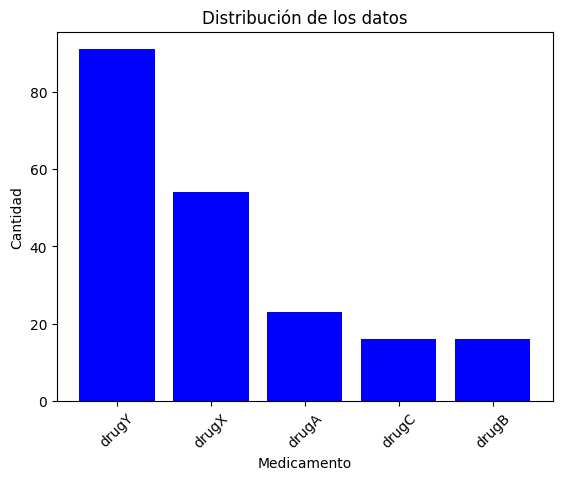

In [ ]:

# Se cuenta cuántas veces aparece cada tipo de medicamento en la columna 'Drug'
category_counts = my_data['Drug'].value_counts()

# Se crea un gráfico de barras para visualizar la distribución de registros por tipo de medicamento
plt.bar(category_counts.index, category_counts.values, color='blue')  # Las barras representan cada medicamento y su frecuencia
plt.xlabel('Medicamento')  # Etiqueta del eje X: tipo de medicamento
plt.ylabel('Cantidad')  # Etiqueta del eje Y: cantidad de registros
plt.title('Distribución de los datos')  # Título del gráfico
plt.xticks(rotation=45)  # Rotación de las etiquetas del eje X para mejorar la legibilidad
plt.show()  # Muestra el gráfico


Esto nos muestra la distribución de las diferentes clases, indicando claramente que Drug X y Drug Y tienen muchos más registros en comparación con los otros tres medicamentos.

## Modelado


Para modelar este conjunto de datos con un clasificador de árbol de decisión, primero dividimos el conjunto de datos en subconjuntos de entrenamiento y prueba. Para ello, separamos la variable objetivo de las variables de entrada.

In [ ]:

# Se define la variable objetivo 'y' como la columna 'Drug', que contiene el nombre del medicamento recetado
y = my_data['Drug']

# Se definen las variables de entrada 'X' eliminando las columnas 'Drug' (nombre del medicamento) y 'Drug_num' (versión numérica del medicamento)
# Esto se hace porque 'Drug' es la variable que queremos predecir, y 'Drug_num' es solo una representación numérica de la misma
X = my_data.drop(['Drug', 'Drug_num'], axis=1)


Ahora, utiliza la función train_test_split() para separar los datos de entrenamiento de los datos de prueba. Podemos usar el 30 % de los datos para pruebas y el resto para entrenar el árbol de decisión.


In [ ]:

# Se divide el conjunto de datos en entrenamiento y prueba utilizando la función train_test_split
# X contiene las variables de entrada, y contiene la variable objetivo (el medicamento)
# test_size=0.3 indica que el 30% de los datos se usarán para pruebas y el 70% para entrenamiento
# random_state=32 asegura que la división sea reproducible (es decir, siempre se obtendrá la misma separación si se usa el mismo valor)
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=32)


Ahora puedes definir el clasificador de árbol de decisión como drugTree y entrenarlo con los datos de entrenamiento.


In [ ]:

# Se crea una instancia del clasificador de árbol de decisión y se guarda en la variable 'drugTree'
# criterion="entropy" indica que se usará la ganancia de información (entropía) como criterio para dividir los nodos
# max_depth=4 limita la profundidad máxima del árbol a 4 niveles, lo que ayuda a evitar el sobreajuste
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth=4)


In [ ]:

# Se entrena el modelo de árbol de decisión 'drugTree' utilizando los datos de entrenamiento
# X_trainset contiene las variables de entrada y y_trainset contiene las etiquetas (medicamentos)
drugTree.fit(X_trainset, y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

### Evaluación


Ahora que has entrenado el árbol de decisión, podemos utilizarlo para generar predicciones sobre el conjunto de prueba.


In [ ]:
# Se generan las predicciones del modelo 'drugTree' utilizando el conjunto de prueba (X_testset)
# Estas predicciones representan los medicamentos que el modelo considera adecuados para los pacientes del conjunto de prueba
tree_predictions = drugTree.predict(X_testset)


Ahora podemos comprobar la precisión de nuestro modelo utilizando la métrica de exactitud (accuracy).

In [ ]:

# Imprime la precisión del modelo de árbol de decisión comparando las etiquetas reales (y_testset)
# con las predicciones generadas por el modelo (tree_predictions). La función accuracy_score calcula
# el porcentaje de predicciones correctas sobre el total de muestras evaluadas.

print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_testset, tree_predictions))

Decision Trees's Accuracy:  0.9833333333333333


Esto significa que el modelo fue capaz de identificar correctamente las etiquetas en el 98,33 % de los casos, es decir, en 59 de las 60 muestras de prueba.


### Visualizar el árbol

Para comprender los criterios de clasificación definidos por el Árbol de Decisión, podemos generar una gráfica del árbol.


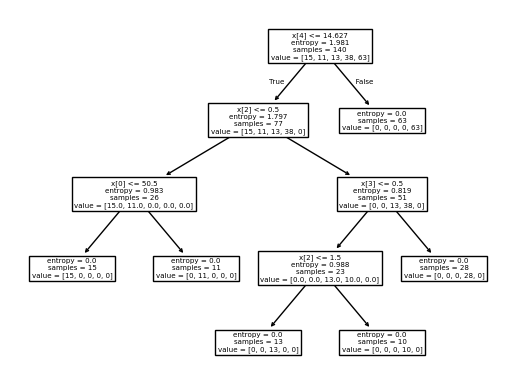

In [ ]:

# Genera y muestra una visualización del Árbol de Decisión entrenado (drugTree),
# lo que permite entender cómo el modelo toma decisiones en función de las características de entrada.
plot_tree(drugTree)
plt.show()


A partir de este árbol, podemos deducir los criterios desarrollados por el modelo para identificar la clase de cada muestra de entrenamiento. Podemos interpretarlos siguiendo los criterios definidos desde la raíz hasta los nodos hoja del árbol.

Por ejemplo, el criterio de decisión para la clase Drug Y es:

 ${Na\_to\_K} \gt 14.627$.

#### Identifica el criterio de decisión para el resto de clases.



**Criterios de decisión del modelo:**

- Drug A: $Na\_to\_K \leq 14.627,\ BP = High,\ Age \leq 50.5$  
- Drug B: $Na\_to\_K \leq 14.627,\ BP = High,\ Age > 50.5$  
- Drug C: $Na\_to\_K \leq 14.627,\ BP = Low,\ Cholesterol \leq High$  
- Drug X: $Na\_to\_K \leq 14.627,\ BP = Normal,\ Cholesterol = High$


#### Si se reduce la profundidad máxima del árbol a 3, ¿cómo se vería afectado el rendimiento del modelo?


In [ ]:
# Se crea un clasificador de árbol de decisión utilizando el criterio de entropía
# y se limita la profundidad máxima del árbol a 3 para evitar sobreajuste.
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Se entrena el modelo con el conjunto de entrenamiento.
drugTree.fit(X_trainset, y_trainset)

# Se generan predicciones sobre el conjunto de prueba.
tree_predictions = drugTree.predict(X_testset)

# Se imprime la precisión del modelo, es decir, el porcentaje de predicciones correctas.
print("Precisión del árbol de decisión: ", metrics.accuracy_score(y_testset, tree_predictions))


Precisión del árbol de decisión:  0.8166666666666667
